In [1]:
!pip install datasets
!apt-get install git-lfs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).

In [2]:
import pandas as pd
import requests
from datasets import load_dataset
import string

import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from transformers import AdamW

import nltk
nltk.download('punkt')
from nltk.stem import PorterStemmer

from transformers import pipeline, tokenization_utils

#dataset
ds = load_dataset('yelp_review_full')

trained = ds['train']
tested = ds['test']

train_df = trained.to_pandas()
test_df = tested.to_pandas()
combined_df = pd.concat([train_df, test_df])

#preprocessing
def remove_punctuation(text):
  for punctuation in string.punctuation:
    text = text.replace(punctuation, '')
  return text

combined_df['text'] = combined_df['text'].apply(remove_punctuation)

#tokenize
combined_df['text'] = combined_df['text'].apply(nltk.word_tokenize)

#sample
nltk.download('stopwords')

# hyperparameters
batch_size = 16
learning_rate = 2e-5
num_epochs = 3

combined_df_sample = combined_df.sample(n=300)
#lowercase
combined_df_sample['text'] = combined_df_sample['text'].apply(lambda x: [word.lower() for word in x])
#stopwords_remove
combined_df_sample['text'] = combined_df_sample['text'].apply(lambda x: [word for word in x if word not in nltk.corpus.stopwords.words('english')])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


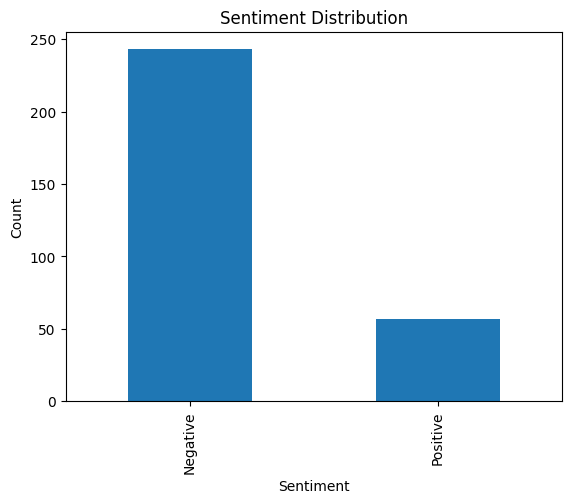

In [9]:
import matplotlib.pyplot as plt

# histogram visualization
combined_df_sample['Sentiment'] = combined_df_sample['label'].apply(lambda x: 'Positive' if x == 1 else 'Negative')

combined_df_sample['Sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


In [3]:
from sklearn.model_selection import train_test_split

X = combined_df_sample.drop(columns=['text'])
y = combined_df_sample['text']

# training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(combined_df_sample['text'], combined_df_sample['label'], test_size=0.2, random_state=42)


In [4]:
# classifiers
classifier1 = pipeline(
    task='sentiment-analysis',
    model='distilbert-base-uncased',
)
classifier2 = pipeline(
    task='sentiment-analysis',
    model='aychang/roberta-base-imdb',
)

# Results
prediction_classifier1 = []
prediction_classifier2 = []
labels_true = []

# loop to get the sentiment and save results in lists created
for review in X_test:  # Loop through the test set
    try:
        prediction_classifier1.append(classifier1(review)[0]['label'])
        prediction_classifier2.append(classifier2(review)[0]['label'])
    except Exception as e:
        print(f"An error occurred: {e}")


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [5]:
from sklearn.metrics import accuracy_score, classification_report
#conversion. pos = 1, neg = 0
labels_true = y_test.tolist()
labels_pred_classifier1 = [1 if pred.lower()[:3] == 'pos' else 0 for pred in prediction_classifier1]
labels_pred_classifier2 = [1 if pred.lower()[:3] == 'pos' else 0 for pred in prediction_classifier2]

# Classification report
report_classifier1 = classification_report(labels_true, labels_pred_classifier1)
report_classifier2 = classification_report(labels_true, labels_pred_classifier2)

# Accuracy score
accuracy_score1 = accuracy_score(labels_true, labels_pred_classifier1)
accuracy_score2 = accuracy_score(labels_true, labels_pred_classifier2)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [6]:
print("Model1 classification report:")
print(report_classifier1)
print("Model2 classification report:")
print(report_classifier2)
print("Model1 accuracy score:",accuracy_score1)
print("Model2 accuracy score:",accuracy_score2)

Model1 classification report:
              precision    recall  f1-score   support

           0       0.17      1.00      0.29        10
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00        13

    accuracy                           0.17        60
   macro avg       0.03      0.20      0.06        60
weighted avg       0.03      0.17      0.05        60

Model2 classification report:
              precision    recall  f1-score   support

           0       0.31      0.50      0.38        10
           1       0.16      0.58      0.25        12
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00        13

    accuracy                           0.20        60
   macro avg       0.09      0.22      0.13        60
weighted avg     

In [7]:
#Sentiment Results

#Classifier1:
# total reviews
print(f"Total reviews classified by classifier1: {len(combined_df_sample['text'])}")
# positive and negative reviews
positive_reviews = sum(labels_pred_classifier1)
negative_reviews = len(combined_df_sample['text']) - positive_reviews
print(f"Positive reviews: {positive_reviews}")
print(f"Negative reviews: {negative_reviews}")

#Classifier2:
# total reviews
print(f"Total reviews classified by classifier2: {len(combined_df_sample['text'])}")
# positive and negative reviews
positive_reviews = sum(labels_pred_classifier2)
negative_reviews = len(combined_df_sample['text']) - positive_reviews
print(f"Positive reviews: {positive_reviews}")
print(f"Negative reviews: {negative_reviews}")


Total reviews classified by classifier1: 300
Positive reviews: 0
Negative reviews: 300
Total reviews classified by classifier2: 300
Positive reviews: 44
Negative reviews: 256
